# **Problem Statement:**

In the era of information overload, distinguishing between genuine news and fake news has become increasingly challenging. Fake news can have significant negative impacts on society, such as spreading misinformation, inciting panic, influencing public opinion, and even affecting democratic processes. Therefore, it is crucial to develop effective methods to automatically identify and filter out fake news from real news.

# **Objective:**

The objective of this machine learning project is to develop a robust model that can accurately classify news articles as either real or fake. By leveraging natural language processing (NLP) techniques and machine learning algorithms, the project aims to build a system that predicts the authenticity of news and improves detection accuracy.

# **About the Dataset:**

1. id: unique id for a news article
2. title: the title of a news article
3. text: the text of the article; could be incomplete
4. subject: subject of news article
5. label: a label that marks whether the news article is real or fake
           0: Real News
           1: Fake News




# Load the libraries

In [1]:
!pip install optuna -q
!pip install nltk spacy -q
!python -m spacy download en_core_web_sm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 18.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import pandas as pd
import numpy as np
import gdown
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from wordcloud import STOPWORDS
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import optuna
from optuna import Trial
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.filterwarnings('ignore')

# Load the dataset

In [3]:
url = f'https://drive.google.com/uc?id=10NHrgshUfiBr__QxQb6s_Ok-twb5NBXg'
output = 'dataset.csv'
gdown.download(url, output, quiet=False)

df = pd.read_csv(output)

Downloading...
From (original): https://drive.google.com/uc?id=10NHrgshUfiBr__QxQb6s_Ok-twb5NBXg
From (redirected): https://drive.google.com/uc?id=10NHrgshUfiBr__QxQb6s_Ok-twb5NBXg&confirm=t&uuid=d9e59950-70bf-4f2f-a75a-aeff96fcab36
To: /content/dataset.csv
100%|██████████| 115M/115M [00:02<00:00, 48.5MB/s]


# Looking into the dataset

In [4]:
df.shape

(44881, 5)

In [5]:
df.head()

,id,title,text,subject,label
0,0,Exclusive: Six U.S. senators urge Obama to pri...,NEW YORK - Six U.S. senators have urged Presid...,politicsNews,0
1,1,Saudi's Kingdom Holding says has support from ...,DUBAI - Saudi Arabian investment firm Kingdom ...,worldnews,0
2,2,WOW! STARBUCKS CEO JUST ACCUSED Whites Of Comm...,Thousands of Starbucks customers cut up their ...,politics,1
3,3,WORKING CLASS REVOLT! OLD SCHOOL JERSEY PATRIO...,HE WILL NOT DIVIDE US .,left-news,1
4,4,WATTERS’ WORLD: “Do you have Obamacare?”…”How ...,NaN,politics,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44881 entries, 0 to 44880
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       44881 non-null  int64 
 1   title    44881 non-null  object
 2   text     44250 non-null  object
 3   subject  44881 non-null  object
 4   label    44881 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.7+ MB


In [7]:
df.isnull().sum()

,0
id,0
title,0
text,631
subject,0
label,0


In [8]:
df.nunique()

,0
id,44881
title,38722
text,38631
subject,8
label,2


# Handling Missing Values

## Drop rows with missing 'text'

In [9]:
df.dropna(subset=['text'], inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44250 entries, 0 to 44880
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       44250 non-null  int64 
 1   title    44250 non-null  object
 2   text     44250 non-null  object
 3   subject  44250 non-null  object
 4   label    44250 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.0+ MB


## Removing duplicate rows

In [11]:
df.drop_duplicates(subset=['title', 'text'], inplace=True)

In [12]:
df.isnull().sum()

,0
id,0
title,0
text,0
subject,0
label,0


In [13]:
df.nunique()

,0
id,38649
title,38275
text,38631
subject,8
label,2


# Exploratory  Data Analysis

In [14]:
df['label'].value_counts()

,count
label,
0,21194
1,17455


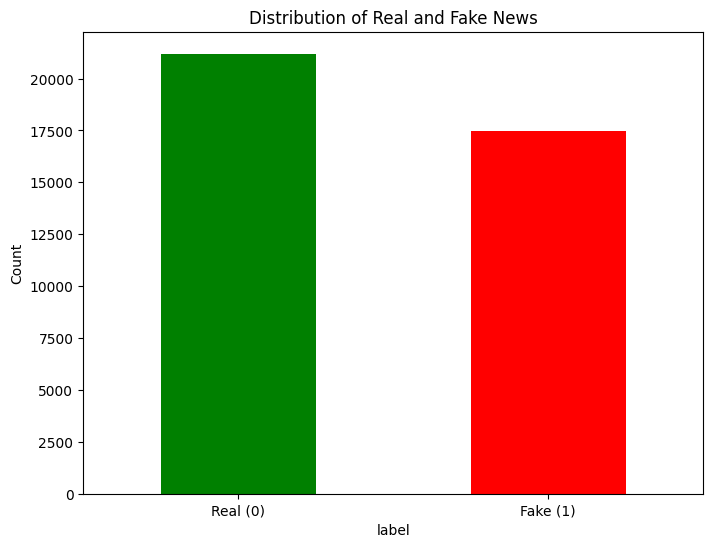

In [15]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Real and Fake News')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Real (0)', 'Fake (1)'], rotation=0)
plt.show()

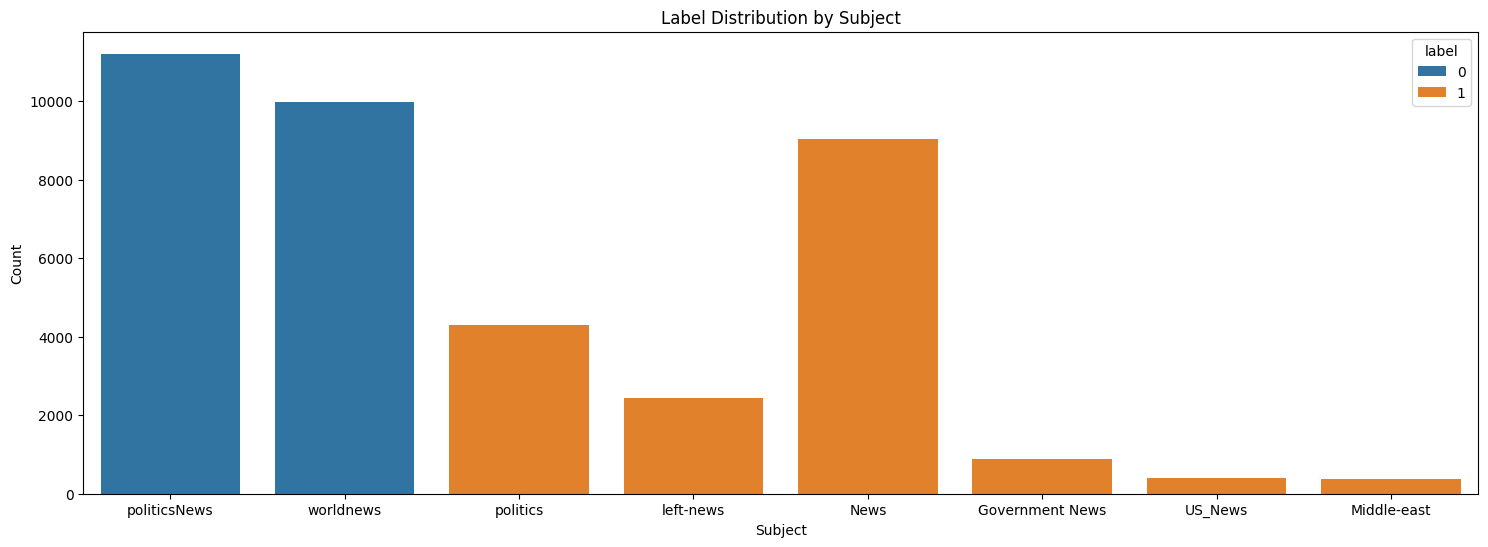

In [16]:
plt.figure(figsize=(18, 6))
sns.countplot(data=df, x='subject', hue='label')

plt.title('Label Distribution by Subject')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.show()

# Feature Engineering

## Combine 'title', and 'text' for feature extraction

In [17]:
df['combined_text'] = df['title'] + ' ' + df['text']

In [18]:
df.head()

,id,title,text,subject,label,combined_text
0,0,Exclusive: Six U.S. senators urge Obama to pri...,NEW YORK - Six U.S. senators have urged Presid...,politicsNews,0,Exclusive: Six U.S. senators urge Obama to pri...
1,1,Saudi's Kingdom Holding says has support from ...,DUBAI - Saudi Arabian investment firm Kingdom ...,worldnews,0,Saudi's Kingdom Holding says has support from ...
2,2,WOW! STARBUCKS CEO JUST ACCUSED Whites Of Comm...,Thousands of Starbucks customers cut up their ...,politics,1,WOW! STARBUCKS CEO JUST ACCUSED Whites Of Comm...
3,3,WORKING CLASS REVOLT! OLD SCHOOL JERSEY PATRIO...,HE WILL NOT DIVIDE US .,left-news,1,WORKING CLASS REVOLT! OLD SCHOOL JERSEY PATRIO...
5,5,Britain close to deal on Brexit bill with EU -...,BRUSSELS/LONDON - Britain has offered to pay m...,worldnews,0,Britain close to deal on Brexit bill with EU -...


## Drop the all the columns except label	and combined_text

In [19]:
df.drop(columns=['id', 'title', 'text', 'subject'], inplace= True)

In [20]:
df.head()

,label,combined_text
0,0,Exclusive: Six U.S. senators urge Obama to pri...
1,0,Saudi's Kingdom Holding says has support from ...
2,1,WOW! STARBUCKS CEO JUST ACCUSED Whites Of Comm...
3,1,WORKING CLASS REVOLT! OLD SCHOOL JERSEY PATRIO...
5,0,Britain close to deal on Brexit bill with EU -...


# Separating the combined_text & label

In [21]:
X = df.drop(columns='label', axis=1)
y = df['label']

In [22]:
X.head(10)

,combined_text
0,Exclusive: Six U.S. senators urge Obama to pri...
1,Saudi's Kingdom Holding says has support from ...
2,WOW! STARBUCKS CEO JUST ACCUSED Whites Of Comm...
3,WORKING CLASS REVOLT! OLD SCHOOL JERSEY PATRIO...
5,Britain close to deal on Brexit bill with EU -...
6,Trump Gives Newt Gingrich’s Wife Job As Vatica...
7,INSANE VIDEO: IT’S GRADUATION TIME…AND THAT ME...
8,Soldiers take over Zimbabwe state broadcaster:...
9,Second group of refugees to leave Australian c...
10,Islamic State claims attack on Damascus police...


In [23]:
y.sample(10)

,label
38487,0
36006,1
39972,0
8448,0
1873,1
16150,0
25914,1
13843,0
656,0
30310,0


# Creating Lemmas

In [24]:
nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    text = re.sub(r'\b\w{1,2}\b', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

X['combined_text'] = X['combined_text'].apply(clean_text).apply(lemmatize_text)

In [25]:
X.head()

,combined_text
0,exclusive six senator urge Obama prioritize cy...
1,Saudi Kingdom Holding say have support from go...
2,WOW starbuck CEO just accuse white commit Sens...
3,WORKING CLASS REVOLT OLD SCHOOL JERSEY PATRIOT...
5,Britain close deal Brexit bill with source BRU...


# Use Term Frequency - Inverse Document Frequency (TF-IDF) for scoring the text

In [26]:
tfidf = TfidfVectorizer(
    token_pattern=r"\b[a-zA-Z]{3,}\b",
    stop_words=list(STOPWORDS),
    min_df=5,
    max_df=0.8
)

In [27]:
tfidf_X = tfidf.fit_transform(X.values.ravel())

In [28]:
tfidf_X

<38649x28562 sparse matrix of type '<class 'numpy.float64'>'
	with 5744195 stored elements in Compressed Sparse Row format>

# Use SVD to transform the sparse TF-IDF matrix into a dense matrix

In [29]:
svd= TruncatedSVD(n_components= 300, algorithm= 'arpack')
svd_mat= svd.fit_transform(tfidf_X)

In [30]:
svd_mat.shape

(38649, 300)

In [31]:
svd_mat

array([[ 0.22463693,  0.10629166, -0.07254035, ..., -0.03667446,
        -0.0245094 , -0.01935089],
       [ 0.09114276,  0.0691577 , -0.0428828 , ...,  0.00920833,
        -0.01006393, -0.02139085],
       [ 0.11228695, -0.03576996,  0.0022411 , ...,  0.00717708,
        -0.0107567 , -0.0174844 ],
       ...,
       [ 0.15373505, -0.1019081 ,  0.08583401, ...,  0.00899764,
        -0.00211708, -0.00286725],
       [ 0.1538438 , -0.03463254, -0.05866174, ..., -0.01532538,
         0.00881361,  0.00618358],
       [ 0.12845372,  0.01474578, -0.07233302, ...,  0.0023643 ,
         0.0205269 ,  0.03167084]])

# Map the SVD matrix with label and split the dataset into training and testing

In [32]:
X_train, X_test, y_train, y_test = train_test_split(svd_mat, y, test_size=0.2, random_state=42)

In [33]:
X_train.shape, X_test.shape

((30919, 300), (7730, 300))

# Training the model

## Logistic Regression model

In [67]:
def objective(trial):
    params = {
        'C': trial.suggest_loguniform('C', 1e-6, 1e2),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }

    if params['solver'] == 'liblinear' and params['penalty'] == 'l1':
        params['solver'] = 'saga'

    model = LogisticRegression(**params, random_state=42)

    score = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-08-20 07:52:45,531] A new study created in memory with name: no-name-d7e22fd9-8d54-443e-bbaa-c9557678a4ea
[I 2024-08-20 07:53:09,506] Trial 0 finished with value: 0.9958169111781691 and parameters: {'C': 1.324795929428527, 'penalty': 'l1', 'solver': 'saga', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9958169111781691.
[I 2024-08-20 07:53:14,307] Trial 1 finished with value: 0.9609088257191539 and parameters: {'C': 2.0975578848494427e-05, 'penalty': 'l2', 'solver': 'saga', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9958169111781691.
[I 2024-08-20 07:53:19,872] Trial 2 finished with value: 0.9185440728043743 and parameters: {'C': 0.009999495074776694, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None}. Best is trial 0 with value: 0.9958169111781691.
[I 2024-08-20 07:53:50,169] Trial 3 finished with value: 0.9962081998373048 and parameters: {'C': 2.511751206250066, 'penalty': 'l1', 'solver': 'saga', 'class_weight': 'balanced'}. Best is tri

In [68]:
print(f'Best parameters for Logistic Regression: {study.best_params}')

Best parameters for Logistic Regression: {'C': 4.573408970457499, 'penalty': 'l1', 'solver': 'saga', 'class_weight': None}


In [69]:
lr_model = LogisticRegression(**study.best_params, random_state=42)
lr_model.fit(X_train, y_train)

LogisticRegression(C=4.573408970457499, penalty='l1', random_state=42,
                   solver='saga')

In [70]:
y_pred_test = lr_model.predict(X_test)

### Model Evaluation

In [71]:
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

print(f'Logistic Regression - Test Accuracy: {test_accuracy}')
print(f'Logistic Regression - Test Precision: {test_precision}')
print(f'Logistic Regression - Test Recall: {test_recall}')
print(f'Logistic Regression - Test F1-score: {test_f1}')

Logistic Regression - Test Accuracy: 0.9745148771021992
Logistic Regression - Test Precision: 0.9758681577398469
Logistic Regression - Test Recall: 0.9664820751967357
Logistic Regression - Test F1-score: 0.971152438131498


Text(0.5, 1.05, 'Confusion_matrix')

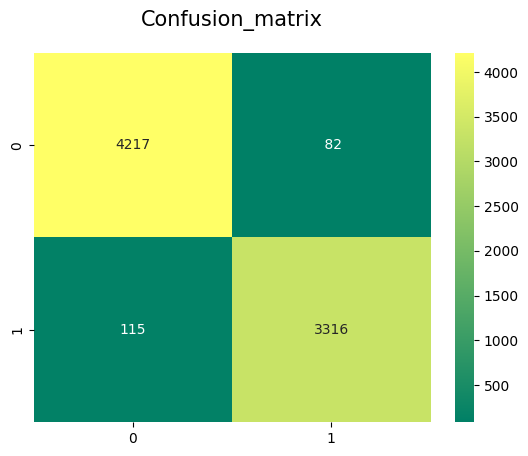

In [72]:
sns.heatmap(confusion_matrix(y_test,y_pred_test),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)



---
### **Test Accuracy: 0.9745148771021992**

---




### Top 20 features

In [66]:
terms = tfidf.get_feature_names_out()
important_features = sorted(zip(tfidf_X.sum(axis=0).A1, terms), reverse=True)

for score, term in important_features[:20]:
    print(f"{term}: {score:.4f}")

trump: 2346.1052
president: 870.0430
will: 750.8227
state: 718.4139
clinton: 684.7325
house: 664.4739
obama: 654.7082
people: 642.1074
year: 589.1555
republican: 585.7945
make: 566.4170
white: 551.4635
donald: 547.9196
one: 543.6012
new: 541.1424
election: 539.7971
government: 538.9564
party: 522.8050
vote: 513.7044
campaign: 500.3952


## Random Forest Classifier model

In [41]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 200, 20),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20)
    }

    model = RandomForestClassifier(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-08-20 04:42:40,704] A new study created in memory with name: no-name-415e833b-bd5f-4b65-89c5-9b35b92942aa
[I 2024-08-20 04:47:32,999] Trial 0 finished with value: 0.9763550918663789 and parameters: {'n_estimators': 180, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.9763550918663789.
[I 2024-08-20 04:49:06,915] Trial 1 finished with value: 0.9640815707252215 and parameters: {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.9763550918663789.
[I 2024-08-20 04:50:04,586] Trial 2 finished with value: 0.9723289867332897 and parameters: {'n_estimators': 40, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.9763550918663789.
[I 2024-08-20 04:54:11,930] Trial 3 finished with value: 0.9778954693613238 and parameters: {'n_estimators': 140, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 3 with val

In [42]:
print(f'Best parameters for Random Forest: {study.best_params}')

Best parameters for Random Forest: {'n_estimators': 200, 'max_depth': 18, 'min_samples_split': 13, 'min_samples_leaf': 6}


In [43]:
rf_model = RandomForestClassifier(**study.best_params, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=18, min_samples_leaf=6, min_samples_split=13,
                       n_estimators=200, random_state=42)

In [44]:
y_pred_test = rf_model.predict(X_test)

### Model Evaluation

In [45]:
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

print(f'Random Forest - Test Accuracy: {test_accuracy}')
print(f'Random Forest - Test Precision: {test_precision}')
print(f'Random Forest - Test Recall: {test_recall}')
print(f'Random Forest - Test F1-score: {test_f1}')

Random Forest - Test Accuracy: 0.926261319534282
Random Forest - Test Precision: 0.9466125507336872
Random Forest - Test Recall: 0.8837073739434567
Random Forest - Test F1-score: 0.9140789870364787


Text(0.5, 1.05, 'Confusion_matrix')

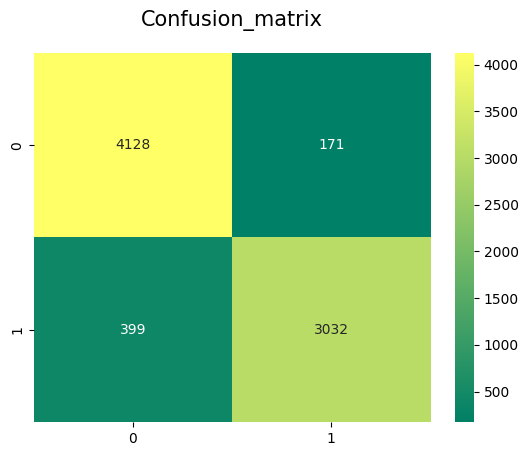

In [46]:
sns.heatmap(confusion_matrix(y_test,y_pred_test),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)



---
### **Test Accuracy: 0.926261319534282**

---




## XGBoost Classifier model

In [48]:
def objective(trial):
  params= {
      'learning_rate': trial.suggest_float('learning_rate',0.001,0.2),
      'max_depth': trial.suggest_int('max_depth',1,8),
      'min_child_weight': trial.suggest_float('min_child_weight',0.5,10),
      'reg_lamda': trial.suggest_float('reg_lamda',0.001,20),
      'n_estimators': trial.suggest_int('n_estimators',20,200),
      'max_leaves': trial.suggest_int('max_leaves',2,20),
      'verbosity':0,
      'objective':'binary:logistic',
      'eval_metric':'logloss',

  }

  model = XGBClassifier(**params, random_state=42)
  score = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()
  return score

study=optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-08-20 06:58:50,660] A new study created in memory with name: no-name-c48bbc2c-fc28-4737-a424-b75a13e13128
[I 2024-08-20 06:59:11,721] Trial 0 finished with value: 0.9865223691078896 and parameters: {'learning_rate': 0.1976106526038932, 'max_depth': 2, 'min_child_weight': 9.049530409240349, 'reg_lamda': 19.159027741790833, 'n_estimators': 159, 'max_leaves': 12}. Best is trial 0 with value: 0.9865223691078896.
[I 2024-08-20 06:59:23,270] Trial 1 finished with value: 0.9685433270132942 and parameters: {'learning_rate': 0.19596383949057475, 'max_depth': 2, 'min_child_weight': 2.198904324253735, 'reg_lamda': 19.19949354253687, 'n_estimators': 117, 'max_leaves': 2}. Best is trial 0 with value: 0.9865223691078896.
[I 2024-08-20 06:59:40,919] Trial 2 finished with value: 0.9838614670678677 and parameters: {'learning_rate': 0.15794324023489, 'max_depth': 3, 'min_child_weight': 3.189670712440185, 'reg_lamda': 9.475700614521251, 'n_estimators': 149, 'max_leaves': 4}. Best is trial 0 with 

In [49]:
print(f'Best parameters for XGBoost: {study.best_params}')

Best parameters for XGBoost: {'learning_rate': 0.18840011949536728, 'max_depth': 5, 'min_child_weight': 7.7606190094474945, 'reg_lamda': 19.60716692012896, 'n_estimators': 188, 'max_leaves': 16}


In [50]:
xgb_model = XGBClassifier(**study.best_params, random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.18840011949536728,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=16,
              min_child_weight=7.7606190094474945, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=188,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [51]:
y_pred_test = xgb_model.predict(X_test)

### Model Evaluation

In [52]:
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

print(f'XGBoost - Test Accuracy: {test_accuracy}')
print(f'XGBoost - Test Precision: {test_precision}')
print(f'XGBoost - Test Recall: {test_recall}')
print(f'XGBoost - Test F1-score: {test_f1}')

XGBoost - Test Accuracy: 0.9620957309184993
XGBoost - Test Precision: 0.9664090368608799
XGBoost - Test Recall: 0.9475371611774993
XGBoost - Test F1-score: 0.9568800588668138


Text(0.5, 1.05, 'Confusion_matrix')

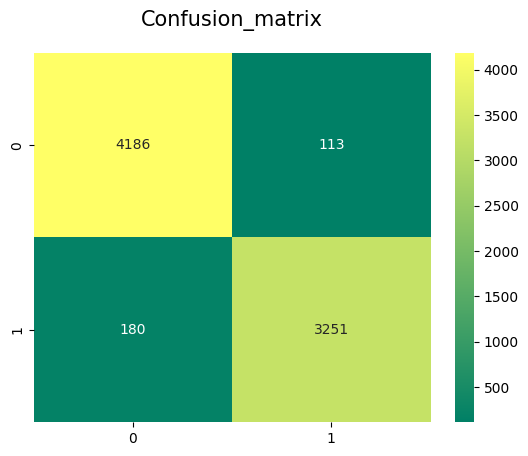

In [53]:
sns.heatmap(confusion_matrix(y_test,y_pred_test),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

---
### **Test Accuracy: 0.9620957309184993**
---

## LighGBM Classifier model

In [54]:
import lightgbm as lgb

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 1, 8),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.5, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 20),
        'n_estimators': trial.suggest_int('n_estimators', 20, 200),
        'num_leaves': trial.suggest_int('num_leaves', 2, 20),
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1
    }

    model = lgb.LGBMClassifier(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-08-20 07:16:02,891] A new study created in memory with name: no-name-dde971b9-7eed-429a-8cd6-0e9028833bbd
[I 2024-08-20 07:16:33,354] Trial 0 finished with value: 0.9773773065556587 and parameters: {'learning_rate': 0.04496795762430604, 'max_depth': 8, 'min_child_weight': 7.29586426807872, 'reg_lambda': 0.9239430078269105, 'n_estimators': 109, 'num_leaves': 14}. Best is trial 0 with value: 0.9773773065556587.
[I 2024-08-20 07:16:44,360] Trial 1 finished with value: 0.9454715188551123 and parameters: {'learning_rate': 0.12964529228095714, 'max_depth': 1, 'min_child_weight': 8.516529123056076, 'reg_lambda': 7.355365055582269, 'n_estimators': 59, 'num_leaves': 18}. Best is trial 0 with value: 0.9773773065556587.
[I 2024-08-20 07:16:59,973] Trial 2 finished with value: 0.9339631803093708 and parameters: {'learning_rate': 0.023922384490760715, 'max_depth': 3, 'min_child_weight': 5.164347698853596, 'reg_lambda': 9.694474411579401, 'n_estimators': 189, 'num_leaves': 2}. Best is trial 

In [55]:
print(f'Best parameters for LightGBM : {study.best_params}')

Best parameters for LightGBM : {'learning_rate': 0.1993713169683928, 'max_depth': 5, 'min_child_weight': 4.600689281849703, 'reg_lambda': 18.99829149259285, 'n_estimators': 188, 'num_leaves': 13}


In [56]:
lgb_model = lgb.LGBMClassifier(**study.best_params, random_state=42)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 14024, number of negative: 16895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.246740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 30919, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.453572 -> initscore=-0.186248
[LightGBM] [Info] Start training from score -0.186248


LGBMClassifier(learning_rate=0.1993713169683928, max_depth=5,
               min_child_weight=4.600689281849703, n_estimators=188,
               num_leaves=13, random_state=42, reg_lambda=18.99829149259285)

In [57]:
y_pred_test = lgb_model.predict(X_test)

### Model Evaluation

In [58]:
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

print(f'LightGBM - Test Accuracy: {test_accuracy}')
print(f'LightGBM - Test Precision: {test_precision}')
print(f'LightGBM - Test Recall: {test_recall}')
print(f'LightGBM - Test F1-score: {test_f1}')

LightGBM - Test Accuracy: 0.9641655886157827
LightGBM - Test Precision: 0.9687871581450654
LightGBM - Test Recall: 0.9498688429029437
LightGBM - Test F1-score: 0.9592347314201619


Text(0.5, 1.05, 'Confusion_matrix')

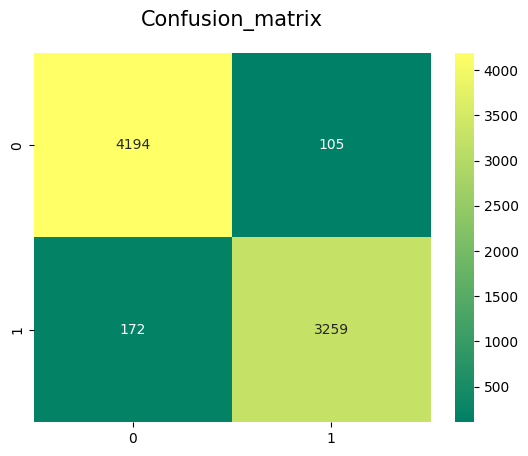

In [59]:
sns.heatmap(confusion_matrix(y_test,y_pred_test),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)

---
### **Test Accuracy: 0.9641655886157827**
---

# Create pipeline

In [73]:
class PreprocessingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")

    def clean_text(self, text):
        text = re.sub(r'\b\w{1,2}\b', '', text)
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def lemmatize_text(self, text):
        doc = self.nlp(text)
        return ' '.join([token.lemma_ for token in doc])

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['combined_text'] = X['combined_text'].apply(self.clean_text).apply(self.lemmatize_text)
        return X

## preprocessing_pipeline

In [74]:
preprocessing_pipeline = Pipeline([
    ('preprocessing', PreprocessingTransformer())
])

## feature_extraction_pipeline and dimensionality_reduction_pipeline

In [75]:
feature_extraction_pipeline = ColumnTransformer([
    ('tfidf', TfidfVectorizer(
        token_pattern=r"\b[a-zA-Z]{3,}\b",
        stop_words=list(STOPWORDS),
        min_df=5,
        max_df=0.8),
     'combined_text')
])

dimensionality_reduction_pipeline = Pipeline([
    ('svd', TruncatedSVD(n_components=300, algorithm='arpack'))
])

## transformation_pipeline

In [76]:
transformation_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('features', feature_extraction_pipeline),
    ('dim_reduction', dimensionality_reduction_pipeline)
])

In [77]:
url = f'https://drive.google.com/uc?id=10NHrgshUfiBr__QxQb6s_Ok-twb5NBXg'
output = 'dataset.csv'
gdown.download(url, output, quiet=False)

df = pd.read_csv(output)
df.dropna(subset=['text'], inplace=True)
df.drop_duplicates(subset=['title', 'text'], inplace=True)
df['combined_text'] = df['title'] + ' ' + df['text']
df.drop(columns=['id', 'title', 'text', 'subject'], inplace=True)
X = df.drop(columns='label')
y = df['label']

X_transformed = transformation_pipeline.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

Downloading...
From (original): https://drive.google.com/uc?id=10NHrgshUfiBr__QxQb6s_Ok-twb5NBXg
From (redirected): https://drive.google.com/uc?id=10NHrgshUfiBr__QxQb6s_Ok-twb5NBXg&confirm=t&uuid=62e6bc5a-3b89-4606-8315-444479c7cc6b
To: /content/dataset.csv
100%|██████████| 115M/115M [00:02<00:00, 56.7MB/s]


## Define Model

In [78]:
model = LogisticRegression(
    C=4.573408970457499,
    penalty='l1',
    solver='saga',
    class_weight=None,
    random_state=42
)

model.fit(X_train, y_train)

LogisticRegression(C=4.573408970457499, penalty='l1', random_state=42,
                   solver='saga')

## Model Evaluation

In [79]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'The Accuracy of the model is: {accuracy}')
print(f'The Precision of the model is: {precision}')
print(f'The Recall of the model is: {recall}')
print(f'The F1 score of the model is: {f1}')

The Accuracy of the model is: 0.9745148771021992
The Precision of the model is: 0.9758681577398469
The Recall of the model is: 0.9664820751967357
The F1 score of the model is: 0.971152438131498


In [80]:
from google.colab import drive
import joblib

drive.mount('/content/drive')
joblib.dump(transformation_pipeline, '/content/drive/My Drive/transformation_pipeline.joblib')
joblib.dump(model, '/content/drive/My Drive/fake_news_model.joblib')

Mounted at /content/drive


['/content/drive/My Drive/fake_news_model.joblib']

# Validate on the New data

In [81]:
def predict_new_input(model, transformation_pipeline):
    id = input("Enter the id: ")
    title = input("Enter the title: ")
    subject = input("Enter the subject: ")
    text = input("Enter the text: ")

    new_data = pd.DataFrame({'id': [id], 'title': [title], 'subject': [subject], 'text': [text]})

    new_data['combined_text'] = new_data['title'] + ' ' + new_data['text']
    new_data.drop(columns=['id', 'title', 'text', 'subject'], inplace=True)

    new_data_transformed = transformation_pipeline.transform(new_data)
    prediction = model.predict(new_data_transformed)

    return prediction[0]

new_prediction = predict_new_input(model, transformation_pipeline)

if new_prediction == 1:
    print('----------------------------------------------')
    print('The predicted label for the new input is: Fake')
else:
    print('----------------------------------------------')
    print('The predicted label for the new input is: Real')

Enter the id: 37924
Enter the title: Russia's Putin, on track for easy re-election, laments dearth of rivals
Enter the subject: worldnews
Enter the text: MOSCOW - Russian President Vladimir Putin said on Thursday he faced no credible high-profile political opponents as he prepared to run for re-election in March, but would work to try to create a more balanced political system. Putin, whom critics have accused of using state TV, the courts and the police to demonize and marginalize the liberal opposition, said earlier this month he would run for re-election in March 2018 - a contest he seems sure to win comfortably and extend his grip on power into a third decade. But in a sign the former KGB officer is keen to strengthen his role as a father of the nation figure rather than as a party political figure, Putin said he planned to run as an independent candidate and garner support from more than one party. The ruling United Russia party has traditionally backed Putin and is likely to do s